# Import Packages

In [30]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger
%matplotlib inline

# keras has the mnist data set built in
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import Input, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D 
from keras.models import Model
from keras.utils import np_utils

# visualization tools
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

# Load Data

In [99]:
# split train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)
print(X_train.max()) # images are 8-bit

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)
255


## Visualize Data

(-0.5, 27.5, 27.5, -0.5)

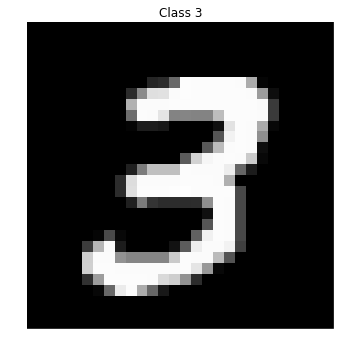

In [167]:
# Training sample
m = 7 # try changing
plt.imshow(X_train[m], cmap='gray', interpolation='none')
plt.title("Class {}".format(y_train[m]))
plt.axis('off')

## Prepare and Normalize 

In [33]:
X_train_flat = X_train.reshape(60000, 784).astype('float32') # flatten image to row vector
X_test_flat = X_test.reshape(10000, 784).astype('float32')
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# normalize
X_train /= 255
X_test /= 255
X_train_flat /= 255
X_test_flat /= 255
print("Training shape flat:", X_train_flat.shape)
print("Testing shape flat:", X_test_flat.shape)
print("Original:", X_train.shape)

Training shape flat: (60000, 784)
Testing shape flat: (10000, 784)
Original: (60000, 28, 28)


### Convert Labels to One-Hot encodings

In [34]:
nb_classes = 10

# notice big Y - storing different name variable for hot encoding
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print("Label matrix shape: ", Y_train.shape)
print("Label matrix shape: ", Y_test.shape)
print(Y_train[m,:])

Label matrix shape:  (60000, 10)
Label matrix shape:  (10000, 10)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


# Construct Neural Network

## 4 steps to build NN in Keras

<b>1) Construct computational graph </b><br>
2) Compile <br>
3) Train <br>
4) Predict <br>
<br>
Lets make 3 different models: 
    - Two Identical Models declared differently
    - Convolutional model

In [35]:
# Sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu')) 
                           
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax')) 

In [36]:
# Functional API - more complex models - allows multiple types of inputs and outputs

# tensor input placeholder with shape input_shape
X_input = Input(shape=X_train_flat.shape[1:])

# Layer 1
X = Dense(512, name='fc0')(X_input)
X = Activation('relu')(X)
    
# Layer 2
X = Dense(512, name='fc1')(X)
X = Activation('relu')(X)
    
#Layer 3 - output
X = Dense(10, name='fc2')(X)
X = Activation('softmax')(X)
    
FCmodel = Model(inputs=X_input, outputs=X, name='FC_Model')

In [144]:
# Convolutional Network

X_in = Input(shape=(28,28,1))
    
# X2 = ZeroPadding2D((3,3))(X_in)
    
# CONV -> BN -> RELU Block applied to X
X2 = Conv2D(32, (5, 5), strides=(1, 1), name='conv0', padding='valid')(X_in)
X2 = BatchNormalization(axis=2, name='bn0')(X2)
X2 = Activation('relu')(X2)

# MAXPOOL
X2 = MaxPooling2D((2, 2), name='max_pool')(X2)

# CONV -> BN -> RELU Block applied to X
X2 = Conv2D(32, (3, 3), strides=(1, 1), name='conv1')(X2)
X2 = BatchNormalization(axis=2, name='bn1')(X2)
X2 = Activation('relu')(X2)

# Flatten X + fully connected
X2 = Flatten()(X2)
X2 = Dense(10, activation='softmax', name='fc')(X2)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
ConvModel = Model(inputs=X_in, outputs=X2, name='Conv_MNIST')

In [145]:
# print summary of sequential model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_12 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_14 (Activation)   (None, 10)                0         
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [146]:
FCmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
fc0 (Dense)                  (None, 512)               401920    
_________________________________________________________________
activation_15 (Activation)   (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               262656    
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 10)                5130      
_________________________________________________________________
activation_17 (Activation)   (None, 10)                0         
Total para

In [147]:
ConvModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 24, 24, 32)        832       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 24, 24, 32)        96        
_________________________________________________________________
activation_24 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 12, 12, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 10, 32)        9248      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 10, 10, 32)        40        
__________

In [148]:
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 2) Compile

Choose loss function and optimizer

In [149]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
FCmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ConvModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 3) Train

In [43]:
# Train Sequential model first
history = model.fit(X_train_flat, Y_train, epochs=3, validation_data=(X_test_flat, Y_test))

print("History output:")
print(history.history)

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 34s 559us/step - loss: 0.1836 - acc: 0.9446 - val_loss: 0.1174 - val_acc: 0.9651
Epoch 2/3
60000/60000 [==============================] - 33s 554us/step - loss: 0.0795 - acc: 0.9750 - val_loss: 0.0914 - val_acc: 0.9710
Epoch 3/3
60000/60000 [==============================] - 32s 527us/step - loss: 0.0571 - acc: 0.9818 - val_loss: 0.0739 - val_acc: 0.9782
History output:
{'val_loss': [0.11738079937323928, 0.091443536845082413, 0.073900880567333654], 'val_acc': [0.96509999999999996, 0.97099999999999997, 0.97819999999999996], 'loss': [0.1836323724862188, 0.079521207103397079, 0.057074758182993776], 'acc': [0.94458333333333333, 0.97504999999999997, 0.98181666666666667]}


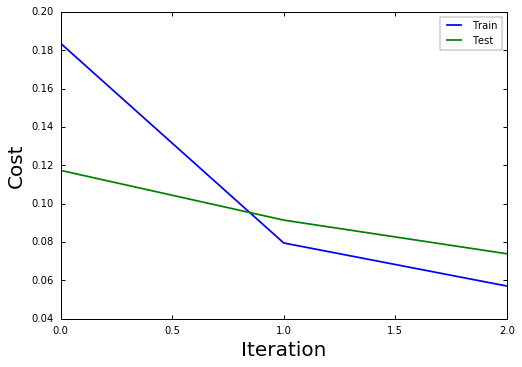

In [53]:
# visualize Cost vs. Iterations as I am training
plt.style.use('seaborn-notebook')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Cost vs Iterations', size=24)
plt.ylabel('Cost', size=20)
plt.xlabel('Iteration', size=20)
plt.legend(['Train', 'Test'])

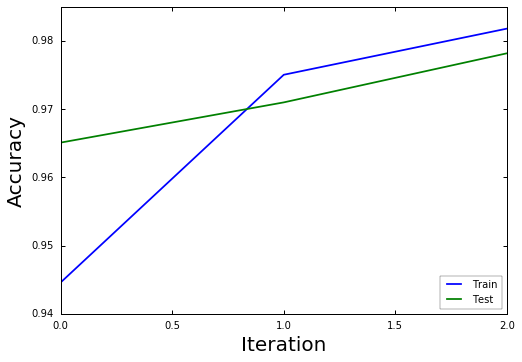

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.title('Accuracy vs Iterations', size=24)
plt.ylabel('Accuracy', size=20)
plt.xlabel('Iteration', size=20)
plt.legend(['Train', 'Test'], loc='lower right')

In [150]:
# Train Conv model
histroy2 = ConvModel.fit(X_train.reshape(60000,28,28,1), Y_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 342s 6ms/step - loss: 0.1184 - acc: 0.9639
Epoch 2/3
60000/60000 [==============================] - 344s 6ms/step - loss: 0.0498 - acc: 0.9849
Epoch 3/3
60000/60000 [==============================] - 322s 5ms/step - loss: 0.0355 - acc: 0.9887


In [151]:
print(histroy2.history)

{'acc': [0.96393333333333331, 0.98491666666666666, 0.98873333333333335], 'loss': [0.11835407077645262, 0.049805337736429645, 0.035453921491955406]}


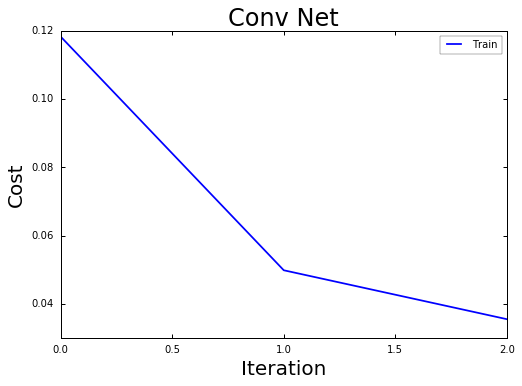

In [152]:
plt.style.use('seaborn-notebook')
plt.plot(histroy2.history['loss'])
plt.title('Conv Net', size=24)
plt.ylabel('Cost', size=20)
plt.xlabel('Iteration', size=20)
plt.legend(['Train'])

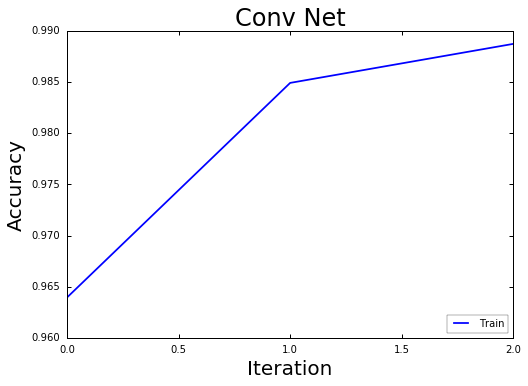

In [153]:
plt.plot(histroy2.history['acc'])
plt.title('Conv Net', size=24)
plt.ylabel('Accuracy', size=20)
plt.xlabel('Iteration', size=20)
plt.legend(['Train', 'Test'], loc='lower right')

### Evaluate

In [154]:
# fully connected model
Cost, Acc = model.evaluate(X_test_flat, Y_test)
print('Cost: ',Cost)
print('Accuracy: ', Acc)

10000/10000 [==============================] - 1s 117us/step
Cost:  0.0739008805673
Accuracy:  0.9782


In [155]:
# Convolutional model
Cost, Acc = ConvModel.evaluate(X_test.reshape(10000,28,28,1), Y_test)
print('Cost: ',Cost)
print('Accuracy: ', Acc)

10000/10000 [==============================] - 34s 3ms/step
Cost:  0.0370094118815
Accuracy:  0.9872


# Predict

Try with Another Image

Image Size:  (28, 28)


(-0.5, 27.5, 27.5, -0.5)

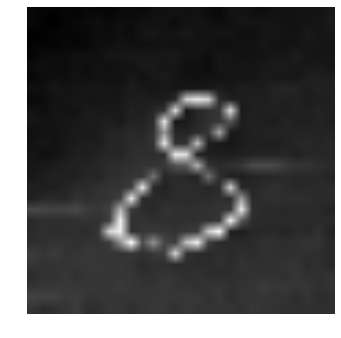

In [170]:
from keras.preprocessing import image
import PIL.ImageOps

img_path = 'digitpictures/Eight.jpg'
#Read image + resize
img = image.load_img(img_path, target_size=(28, 28))

# Convert to graysclae 
img = img.convert('L')

# Take inverse. MNIST recognizes bright foreground with dark background
inv_img = PIL.ImageOps.invert(img)

print('Image Size: ', img.size)
#Display image
plt.imshow(inv_img, 'gray')
plt.grid('off')
plt.axis('off')

In [171]:
from keras.applications.imagenet_utils import preprocess_input

# convert to array, and reshape
x = image.img_to_array(inv_img).reshape(1,784)
x2 = image.img_to_array(inv_img)
print('x shape: ', x.shape)

# print(x.min())

#normalize
x /= 255
x2 /= 255
x2 = x2.reshape(1,28,28,1)
print('x2 shape: ', x2.shape)
print('Fully Connected Model')
print(model.predict(x))
print(np.argmax(model.predict(x)))
print()
print('Convolutional Model')
print(ConvModel.predict(x2))
print(np.argmax(ConvModel.predict(x2.reshape(1,28,28,1))))

x shape:  (1, 784)
x2 shape:  (1, 28, 28, 1)
Fully Connected Model
[[ 0.06296762  0.04828931  0.22458991  0.13131703  0.02254599  0.0630285
   0.05035728  0.06660128  0.26782778  0.06247529]]
8

Convolutional Model
[[ 0.00229753  0.46202338  0.12524097  0.01546961  0.00732368  0.1977333
   0.00342286  0.17435081  0.00483365  0.00730416]]
1


## Topics for next week ???

<ul>
    <li>Transfer Learning
    <li>Convolutional Neural Nets
    <li>Tesnorflow tutorial
    <li>Bias Variance
    <li>Someone's research 
</ul>

## Acknowledgment

Most of this material was written by Xavier Snelgrove <br>
https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb
<br><br>

Also Available from my github - https://github.com/AdamRauff/Deep-Learning